# 0. Introduction
In this notebook we are going to perform a Customer Analytics on online retail data. Customer analytics is a powerful analytics technique to group a customers and enable the business to customize their product offering and marketing strategy.

For this Customer Analytics Projects we will perform:
-  Cohort Retention Rate Analysis
-  Recency, Frequency, Monetary Analysis
-  Customer Segmentation on RFM data


**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

1.  Cohort analysis is a descriptive analytics tool. It groups the customers into mutually exclusive cohorts - which are then measured over time. Cohort analysis provides insights and it helps with understanding the trends better by providing insights on metrics across both the product and the customer lifecycle


2. RFM analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns 

   RFM Analysis calculate a three customers behavior metrics:
   - Recency measures how recent was each customer's last purchase
   - Frequency measures how many purchases the customer has done in a given period of time
   - Monetary measures how much has the customer spent in a given period of time
   
   
3. Customer segmentation is the process by which you divide your customers up based on common characteristics, for this project we will use a KMeans algorthims to identify customer clusters based on their recency, frequency, and monetary

# 1. Import libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sns.set()

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Import and read data

In [2]:
raw_data = pd.read_excel('online_retail_II.xlsx')

In [3]:
raw_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


# 3. Data cleaning

In this dataset we have a Quantity and UnitPrice columns contains a negative values. We will drop the negative values on Quantity and UnitPrice columns

In [5]:
# Subset data only contains positive values
cleaned_data = raw_data[(raw_data['Quantity'] > 0) & (raw_data['Price'] > 0)]

In [6]:
cleaned_data.shape

(511566, 8)

In [7]:
# Investigating null values
cleaned_data.isnull().sum()

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    103902
Country             0
dtype: int64

In [8]:
# Visualize the null values on customer id
cleaned_data[cleaned_data['Customer ID'].isnull()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
525143,538154,82599,FANNY'S REST STOPMETAL SIGN,1,2010-12-09 16:35:00,4.21,NaN,United Kingdom
525144,538154,84029E,RED WOOLLY HOTTIE WHITE HEART.,5,2010-12-09 16:35:00,8.47,NaN,United Kingdom
525145,538154,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2010-12-09 16:35:00,8.47,NaN,United Kingdom
525146,538154,85099B,JUMBO BAG RED RETROSPOT,1,2010-12-09 16:35:00,4.21,NaN,United Kingdom


There is a 103902 null values on Customer ID column. For the purpose of this project we will just drop the null values on the customer id column

In [9]:
cleaned_data.dropna(subset=['Customer ID'], axis=0, inplace=True)

In [10]:
cleaned_data.shape

(407664, 8)

# 4. Exploratory Data Analysis

In [11]:
# Investigate number of unique values each feature 

for col in cleaned_data:
    unique = cleaned_data[col].unique()
    nr_values = len(unique)
    if nr_values < 10:
        print('The number of values for feature {} :{} -- {}'.format(col, nr_values,unique))
    else:
        print('The number of values for feature {} :{}'.format(col, nr_values))

The number of values for feature Invoice :19213
The number of values for feature StockCode :4017
The number of values for feature Description :4444
The number of values for feature Quantity :343
The number of values for feature InvoiceDate :18008
The number of values for feature Price :448
The number of values for feature Customer ID :4312
The number of values for feature Country :37


In [12]:
# Create a Total column
cleaned_data['Total'] = cleaned_data['Quantity'] * cleaned_data['Price']
cleaned_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


## 4.1 Feature Analysis

### 4.1.1 Number of Orders

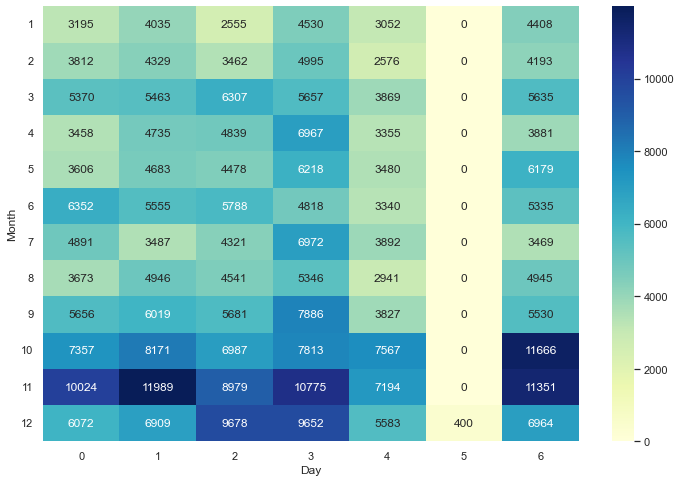

In [13]:
orders = pd.crosstab(cleaned_data['InvoiceDate'].dt.month, cleaned_data['InvoiceDate'].dt.dayofweek, 
           values=cleaned_data['Invoice'], aggfunc='count').round(0).fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(orders, annot=True, cmap='YlGnBu', fmt='.5g', cbar=True)
plt.ylabel('Month')
plt.xlabel('Day')
plt.yticks(rotation=0)
plt.show()

Several marks:
- We have missing order data record on Saturday from January to November
- Highest number of order is in november tuesday with 11989 invoice numbers
- Lowest number of order is in december saturday with 400 invoice numbers

### 4.1.2 Top 10 Products by Quantity

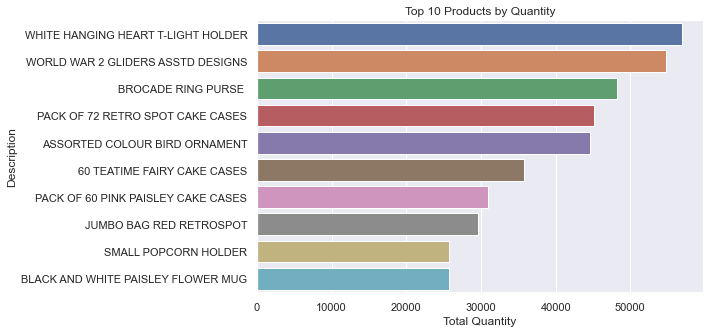

In [14]:
top_10_products_by_quantity = cleaned_data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).reset_index().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x='Quantity',y='Description', data = top_10_products_by_quantity)
plt.xlabel('Total Quantity')
plt.title('Top 10 Products by Quantity')
plt.show()

### 4.1.3 Top 10 Products by Sales

In [15]:
top_10_products_by_sales = cleaned_data.groupby('Description')['Total'].sum().sort_values(ascending=False).reset_index().head(10)
top_10_products_by_sales

,Description,Total
0,WHITE HANGING HEART T-LIGHT HOLDER,151624.31
1,REGENCY CAKESTAND 3 TIER,143893.35
2,Manual,98560.64
3,ASSORTED COLOUR BIRD ORNAMENT,70493.83
4,JUMBO BAG RED RETROSPOT,51759.30
5,POSTAGE,48741.08
6,ROTATING SILVER ANGELS T-LIGHT HLDR,40186.65
7,PAPER CHAIN KIT 50'S CHRISTMAS,36933.50
8,PARTY BUNTING,35035.90
9,EDWARDIAN PARASOL NATURAL,34044.75


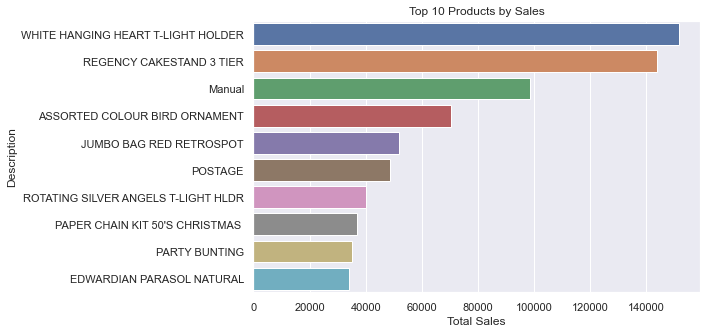

In [16]:
plt.figure(figsize=(8,5))
sns.barplot(x='Total',y='Description', data = top_10_products_by_sales)
plt.title('Top 10 Products by Sales')
plt.xlabel('Total Sales')
plt.show()

We can see that **WHITE HANGING HEART T-LIGHT HOLDER** is the most purchased item and also the highest sales

### 4.1.4 Customer Transaction per Year

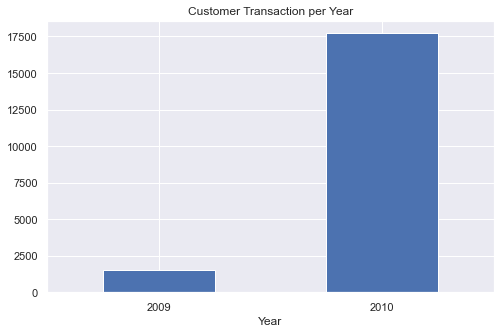

In [17]:
# Creating feature for year 
cleaned_data['Year'] = cleaned_data['InvoiceDate'].dt.year
transaction_per_year = cleaned_data.groupby('Year')['Invoice'].nunique()

# Visualize the transaction per year
transaction_per_year.plot(kind='bar', figsize=(8,5))
plt.title('Customer Transaction per Year')
plt.xticks(rotation=0)
plt.show()

We can see there is a huge difference on number of transaction in 2009 and 2010. This is make sense since there was only 1 month in 2009 in the dataset

### 4.1.5 Average monthly transaction 

In [18]:
avg_month_transaction = cleaned_data[['InvoiceDate','Invoice']].set_index('InvoiceDate').resample('M').mean()
avg_month_transaction

,Invoice
InvoiceDate,
2009-12-31,491151.599337
2010-01-31,494948.374558
2010-02-28,497981.985835
2010-03-31,501499.543760
2010-04-30,505017.904167
2010-05-31,508526.868175
2010-06-30,512318.555310
2010-07-31,515939.501702
2010-08-31,519306.468665


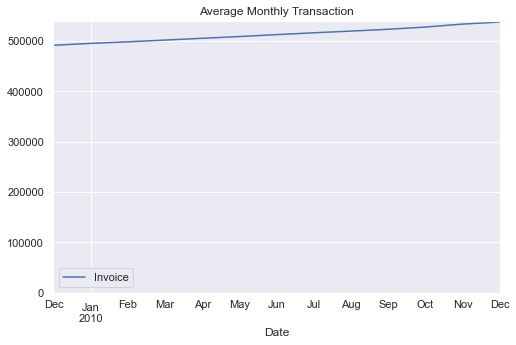

In [19]:
avg_month_transaction.plot(figsize=(8,5))
plt.ylim(0)
plt.title('Average Monthly Transaction')
plt.xlabel('Date')
plt.show()

We can see that, every month we have an increase of the number transaction every month

### 4.1.6 Monthly total revenue

In [20]:
month_total_revenue = cleaned_data[['InvoiceDate','Total']].set_index('InvoiceDate').resample('M').sum()
month_total_revenue 

,Total
InvoiceDate,
2009-12-31,686654.160
2010-01-31,557319.062
2010-02-28,506371.066
2010-03-31,699608.991
2010-04-30,594609.192
2010-05-31,599985.790
2010-06-30,639066.580
2010-07-31,591636.740
2010-08-31,604242.650


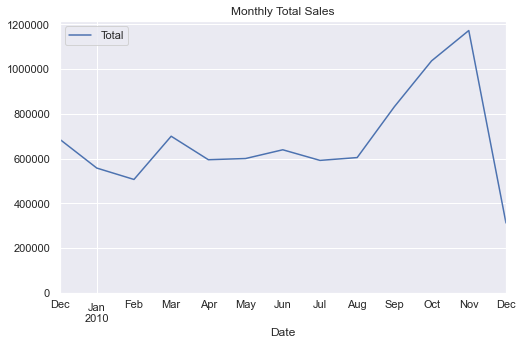

In [21]:
month_total_revenue.plot(figsize=(8,5))
plt.title('Monthly Total Sales')
plt.ylim(0)
plt.xlabel('Date')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

We can see that our highest average sales in January with 25.594446, then February until August there is no significant increase, but in September our average sales increase with 24.035810 then drop again in October and November

### 4.1.7 Top 10 Countries by revenue

In [22]:
top_10_countries = cleaned_data.groupby('Country')['Total'].sum().sort_values(ascending=False).reset_index().head(10)
top_10_countries

,Country,Total
0,United Kingdom,7414755.963
1,EIRE,356085.210
2,Netherlands,268786.000
3,Germany,202395.321
4,France,146215.420
5,Sweden,53171.390
6,Denmark,50906.850
7,Spain,47601.420
8,Switzerland,43921.390
9,Australia,31446.800


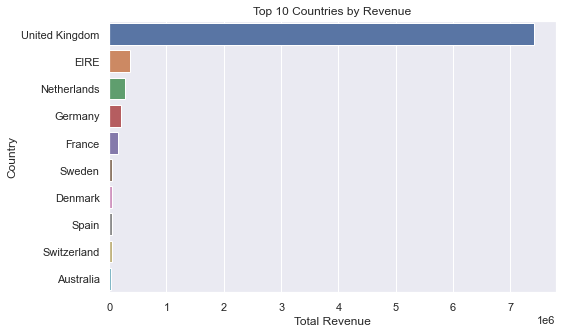

In [23]:
plt.figure(figsize=(8,5))
sns.barplot(x='Total', y='Country', data=top_10_countries)
plt.xlabel('Total Revenue')
plt.title('Top 10 Countries by Revenue')
plt.show()

### 4.1.8 Total customers per Country

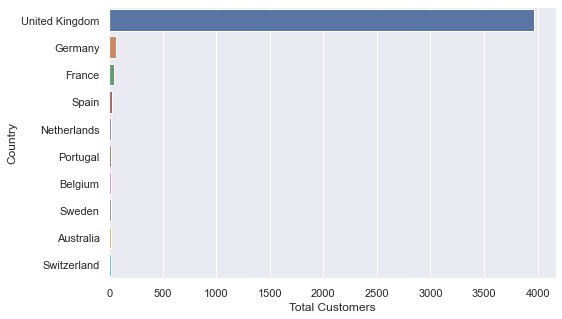

In [24]:
customer_per_country = cleaned_data.groupby('Country')['Customer ID'].nunique().sort_values(ascending=False).reset_index().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x='Customer ID', y='Country', data=customer_per_country)
plt.xlabel('Total Customers')
plt.show()

We can see that majority of our customers in this dataset are from United Kingdom

## 4.2 Cohort retention rate analysis

We will segment customers into acquisition cohorts based on the month they made their first purchase. We will then assign the cohort index to each purchase of the customer. It will represent the number of months since the first transaction. We will group customers into cohorts based on the month of their first purchase. Then we will mark each transaction based on its relative time period since the first purchase.

In [25]:
# Define a function that will parse the year and month
def get_year_month(x):
    return dt.datetime(x.year, x.month, 1)

In [26]:
cleaned_data['InvoiceMonth'] = cleaned_data['InvoiceDate'].apply(get_year_month)

In [27]:
cleaned_data.drop('Year', axis=1, inplace=True)
cleaned_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total,InvoiceMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12-01
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009-12-01
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009-12-01


In [28]:
groupby_cust_invoice_month = cleaned_data.groupby('Customer ID')['InvoiceMonth']
cleaned_data['CohortMonth'] = groupby_cust_invoice_month.transform('min')
cleaned_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total,InvoiceMonth,CohortMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40,2009-12-01,2009-12-01
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009-12-01,2009-12-01
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009-12-01,2009-12-01
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80,2009-12-01,2009-12-01
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,2009-12-01,2009-12-01
...,...,...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,5.90,2010-12-01,2009-12-01
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75,2010-12-01,2009-12-01
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75,2010-12-01,2009-12-01
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,7.50,2010-12-01,2009-12-01


In [29]:
# Define a function that will parse the date
def get_date(data, column):
    day = cleaned_data[column].dt.day
    month = cleaned_data[column].dt.month
    year = cleaned_data[column].dt.year
    return day, month, year 

In [30]:
# Get the date from the InvoiceDay column
_ , invoice_month, invoice_year = get_date(cleaned_data, 'InvoiceMonth')

# Get the date from the CohortMonth column
_ , cohort_month, cohort_year = get_date(cleaned_data, 'CohortMonth')

We will calculate the difference in years and month between the moment of the invoice and the moment the cohort was created

In [31]:
# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Extract the difference from all previous values
cleaned_data['CohortIndex'] = years_diff * 12 + months_diff


We will select the customer ID column, count the number of unique values, store it as cohort_data, and reset its index then create a pivot with monthly cohort in the index, cohort index in the columns and the customer ID in the values.

In [32]:
group = cleaned_data.groupby(['CohortMonth', 'CohortIndex'])

# Count the number of unique values per customer ID
cohort_data = group['Customer ID'].apply(pd.Series.nunique).reset_index()

# Create a pivot 
cohort_counts = cohort_data.pivot(index='CohortMonth', columns=['CohortIndex'], values='Customer ID')

# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Format the date to name of the months and year 
retention.index = retention.index.strftime('%B %Y')

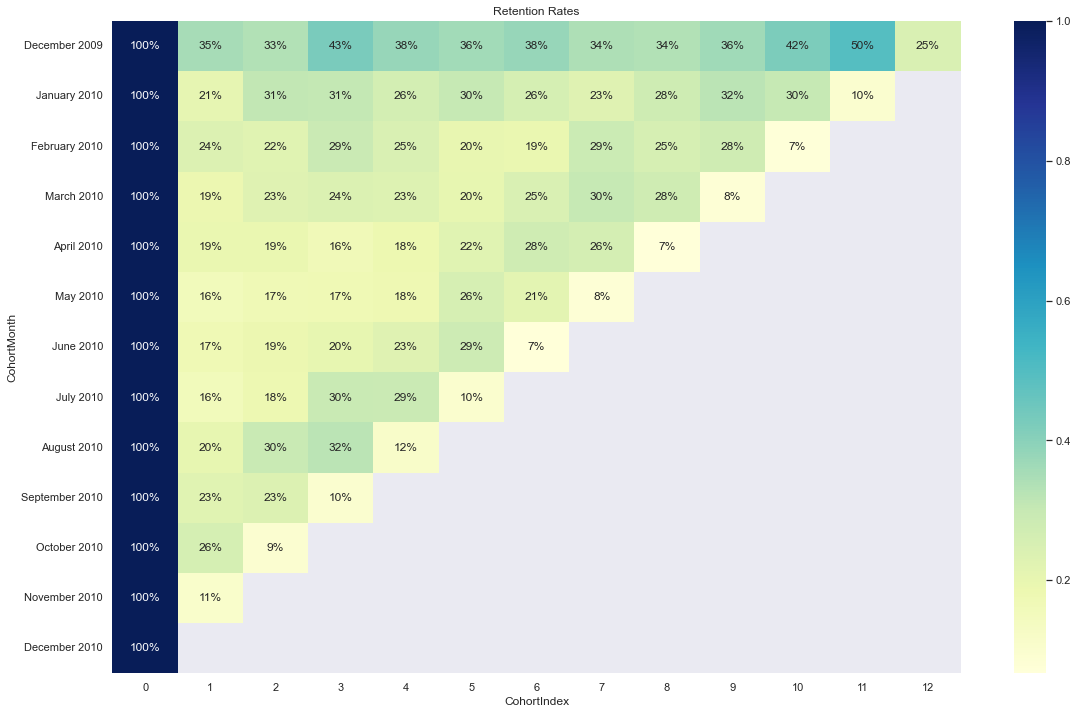

In [33]:
plt.figure(figsize=(19,12))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('Retention Rates')
plt.show()

Several remarks:
- December 2009 is the highest retention rate with 35% active customers after 1 month acquisition 
- January 2010 we have only 21% active customers after 1 month acquisitions, but in the second and third month after acquisition our active customers increase to 31%
- In March, April, May, June, July our active customers after 1 month acquisitions are relatively low that under 20% are still active
- November 2010 is the lowest retention rate with only 11% active customers after 1 month acquisition


## 4.3 Recency, Frequency, Monetary Value analysis

RFM modelling is a marketing analysis technique used to evaluate a customer's behaviour. It groups customers based on their transaction history – how recently, how often and how much did they buy. RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

Behavioral customer segmentation based on three metrics:
- Recency
- Frequency
- Monetary Value

In this project we are going to implement percentile-based grouping on the RFM values


In [34]:
# Making a copy from cleaned data 
data_rfm = cleaned_data.copy()

In [35]:
data_rfm.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total,InvoiceMonth,CohortMonth,CohortIndex
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12-01,2009-12-01,0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01,2009-12-01,0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01,2009-12-01,0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009-12-01,2009-12-01,0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009-12-01,2009-12-01,0


First, let's see the minimun date and the maximum date in the dataset

In [36]:
print(data_rfm['InvoiceDate'].min()) 
print(data_rfm['InvoiceDate'].max())

2009-12-01 07:45:00
2010-12-09 20:01:00


We would create a hypothetical date as if we are doing analysis recently

In [37]:
# Creating a snapshot date
snapshot_date = max(data_rfm['InvoiceDate']) + dt.timedelta(days=1) 
print(snapshot_date)

2010-12-10 20:01:00


#### 4.3.1 Calculate RFM values

In [38]:
# Calculate Recency, Frequency and Monetary value for each customer 
data_rfm = data_rfm.groupby('Customer ID').agg({'InvoiceDate':lambda x: (snapshot_date - x.max()).days,
                                              'Invoice':'count',
                                              'Total':'sum'})


In [39]:
# Rename the columns
data_rfm.rename(columns={'InvoiceDate':'Recency',
                        'Invoice':'Frequency',
                        'Total':'MonetaryValue'}, inplace=True)

data_rfm

,Recency,Frequency,MonetaryValue
Customer ID,,,
12346.0,165,33,372.86
12347.0,3,71,1323.32
12348.0,74,20,222.16
12349.0,43,102,2671.14
12351.0,11,21,300.93
...,...,...,...
18283.0,18,230,641.77
18284.0,67,28,461.68
18285.0,296,12,427.00


#### 4.3.2 Calculate groups for recency, frequency, monetary value

In [40]:
# Create label for Recency and we reserve the order 
recency_labels = range(4, 0, -1) 

# Create label for frequency
frequency_labels = range(1, 5)

# Create labels for MonetaryValue 
monetary_labels = range(1, 5)

# Assign these labels to three equal percentile groups 
recency_groups = pd.qcut(data_rfm['Recency'], q=4, labels=recency_labels)

# Assign these labels to three equal percentile groups 
frequency_groups = pd.qcut(data_rfm['Frequency'], q=4, labels=frequency_labels)

# Assign these labels to three equal percentile groups
monetary_groups = pd.qcut(data_rfm['MonetaryValue'], q=4, labels=monetary_labels)

# Create new columns R_quartile
data_rfm = data_rfm.assign(R_quartile = recency_groups.values)

# Create new columns R_quartile
data_rfm = data_rfm.assign(F_quartile = frequency_groups.values)

# Create new column M_quartile
data_rfm = data_rfm.assign(M_quartile = monetary_groups.values)


In [41]:
# Calculate RFM_Score
data_rfm['RFM_Score'] = data_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)



In [42]:
# Creating a RFM_Class column
data_rfm['RFM_Class'] = data_rfm['R_quartile'].astype('str') + data_rfm['F_quartile'].astype('str') + data_rfm['M_quartile'].astype('str')

In [43]:
data_rfm

,Recency,Frequency,MonetaryValue,R_quartile,F_quartile,M_quartile,RFM_Score,RFM_Class
Customer ID,,,,,,,,
12346.0,165,33,372.86,1,2,2,5,122
12347.0,3,71,1323.32,4,3,3,10,433
12348.0,74,20,222.16,2,2,1,5,221
12349.0,43,102,2671.14,3,3,4,10,334
12351.0,11,21,300.93,4,2,1,7,421
...,...,...,...,...,...,...,...,...
18283.0,18,230,641.77,4,4,2,10,442
18284.0,67,28,461.68,2,2,2,6,222
18285.0,296,12,427.00,1,1,2,4,112


## 4.4 Analyzing RFM table

After created a RFM table, now we are going to analyze to generate insights that would help the stakeholders

### 4.4.1 Top 10 largest RFM class

In [44]:
data_rfm.groupby('RFM_Class').size().sort_values(ascending=False)[:10]

RFM_Class
444    406
111    384
344    223
211    175
122    169
333    160
222    160
233    151
322    143
433    134
dtype: int64

### 4.4.2 Summary metrics per RFM score

In [45]:
data_rfm.groupby('RFM_Score').agg({'Recency':'mean',
                                  'Frequency':'mean',
                                  'MonetaryValue':'mean'})

,Recency,Frequency,MonetaryValue
RFM_Score,,,
3,252.864583,8.208333,156.685807
4,177.427110,15.795396,235.742611
5,145.631347,21.611479,363.292188
6,92.874200,27.496802,597.005394
7,84.260081,41.171371,827.928105
8,61.091723,59.243848,1184.024682
9,46.488636,84.009091,1591.603682
10,37.480769,134.028846,2421.358950
11,21.600000,203.087805,3713.990276


- The lowest RFM score has the highest recency average and the lowest frequency and monetaryvalue average
- The highest RFM score has the lowest recency average and the highest frequency and monetaryvalue average

### 4.4.3 Best customers

In [46]:
data_rfm[data_rfm['RFM_Class'] == '444']

,Recency,Frequency,MonetaryValue,R_quartile,F_quartile,M_quartile,RFM_Score,RFM_Class
Customer ID,,,,,,,,
12415.0,11,212,19543.84,4,4,4,12,444
12431.0,9,170,4370.52,4,4,4,12,444
12433.0,2,286,7205.39,4,4,4,12,444
12471.0,10,677,20139.74,4,4,4,12,444
12472.0,5,572,11308.48,4,4,4,12,444
...,...,...,...,...,...,...,...,...
18168.0,8,273,2600.33,4,4,4,12,444
18225.0,1,308,7545.14,4,4,4,12,444
18226.0,14,286,6650.83,4,4,4,12,444


There is a 406 customers that grouped into our best class, total 406 customers are have a low recency, and high frequency and monetaryvalue

### 4.4.4 Customers that more likely to churn

In [47]:
data_rfm[(data_rfm['R_quartile'] ==1) |(data_rfm['R_quartile'] == 2)]

,Recency,Frequency,MonetaryValue,R_quartile,F_quartile,M_quartile,RFM_Score,RFM_Class
Customer ID,,,,,,,,
12346.0,165,33,372.86,1,2,2,5,122
12348.0,74,20,222.16,2,2,1,5,221
12355.0,203,22,488.21,1,2,2,5,122
12359.0,61,117,2563.36,2,4,4,10,244
12361.0,98,19,321.35,2,2,2,6,222
...,...,...,...,...,...,...,...,...
18279.0,155,13,231.34,1,1,1,3,111
18281.0,213,10,120.32,1,1,1,3,111
18284.0,67,28,461.68,2,2,2,6,222


We have 2122 total customers that more likely to churn, our customers have a pretty high recency values

### 4.4.5 The lost customers

In [48]:
print('Average Recency: ', data_rfm[data_rfm['RFM_Class'] == '111']['Recency'].mean())
data_rfm[data_rfm['RFM_Class'] == '111']

Average Recency:  252.86458333333334


,Recency,Frequency,MonetaryValue,R_quartile,F_quartile,M_quartile,RFM_Score,RFM_Class
Customer ID,,,,,,,,
12362.0,374,1,130.00,1,1,1,3,111
12392.0,227,7,234.75,1,1,1,3,111
12404.0,318,1,63.24,1,1,1,3,111
12416.0,292,11,202.56,1,1,1,3,111
12466.0,318,1,56.73,1,1,1,3,111
...,...,...,...,...,...,...,...,...
18254.0,217,16,267.90,1,1,1,3,111
18267.0,308,17,269.37,1,1,1,3,111
18273.0,226,1,153.00,1,1,1,3,111


We have total 384 total customers that have a high recency and low frequency and monetaryvalue.The average recency is 253 days

## 5. Customer Segmentation with KMeans

For the customer segmentation we will add new features called Tenure. Tenure calculate the time since first transaction, it defines how long the customer has been with the company

In [49]:
# Calculate Recency, Tenure, Frequency and Monetary value for each customer 
data_segment = cleaned_data.groupby('Customer ID').agg({'InvoiceDate':[lambda x: (snapshot_date - x.max()).days,
                                                       lambda x: (snapshot_date - x.min()).days],
                                              'Invoice':'count',
                                              'Total':'sum'})

data_segment.columns = ['Recency','Tenure','Frequency','MonetaryValue']
data_segment

,Recency,Tenure,Frequency,MonetaryValue
Customer ID,,,,
12346.0,165,361,33,372.86
12347.0,3,40,71,1323.32
12348.0,74,74,20,222.16
12349.0,43,225,102,2671.14
12351.0,11,11,21,300.93
...,...,...,...,...
18283.0,18,294,230,641.77
18284.0,67,67,28,461.68
18285.0,296,296,12,427.00


### 5.1 Data Preprocessing

First, we will visualize the distributions of each feature

In [50]:
features = ['Recency','Tenure','Frequency','MonetaryValue']

In [51]:
# Build a function for visualize distribution
def plotting_features_distribution(features):
    plt.figure(figsize=(15,12))
    plt.subplots_adjust(hspace=0.5)   

    for n, feature in enumerate(features):
        # add a new subplot iteratively
        ax = plt.subplot(2, 2, n + 1)

        # filter df and plot ticker on the new subplot axis
        sns.histplot(data_segment[feature], kde=True)

        # chart formatting
        ax.set_title(feature.title())
        ax.set_xlabel("")

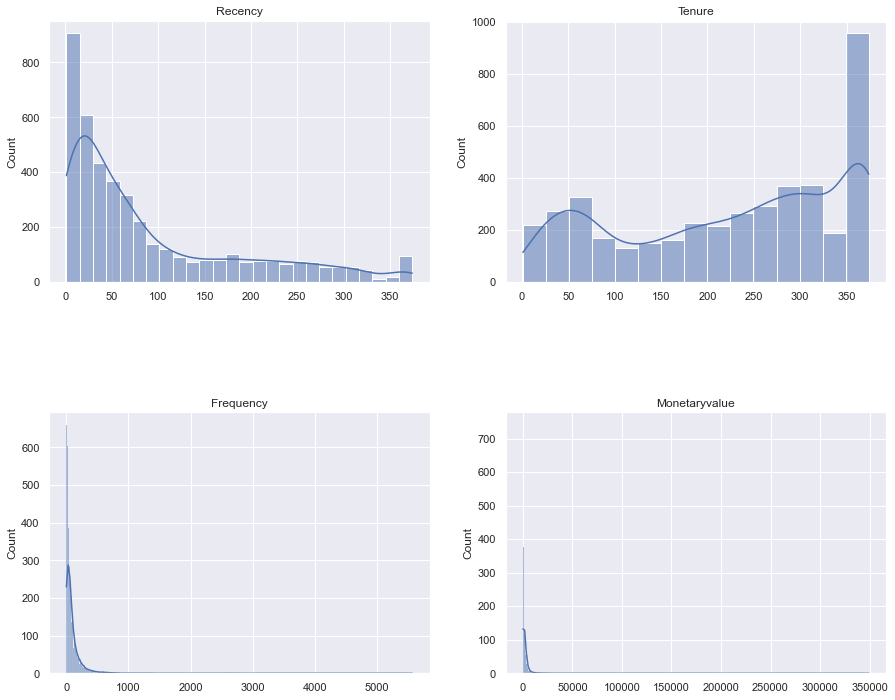

In [52]:
plotting_features_distribution(features)

### 5.1.1 Scaling data distributions

KMeans algorithm works best with all variables have symmetrical distributions, which means the distributions is not skewed. It's important ensuring that each metric gets an equal weight in the k-means calculation. We will manage the skewness distribution with log function from numpy and StandardScaler

In [53]:
data_log = np.log(data_segment)

In [54]:
scaler = StandardScaler()
scaler.fit(data_log)
data_log_scaled = scaler.transform(data_log)

In [55]:
data_log_scaled = pd.DataFrame(data_log_scaled, columns=data_segment.columns)

In [56]:
# Build a function for visualize distribution
def plotting_features_distribution(features):
    plt.figure(figsize=(15,12))
    plt.subplots_adjust(hspace=0.5)   

    for n, feature in enumerate(features):
        # add a new subplot iteratively
        ax = plt.subplot(2, 2, n + 1)

        # filter df and plot ticker on the new subplot axis
        sns.histplot(data_log_scaled[feature], kde=True)

        # chart formatting
        ax.set_title(feature.title())
        ax.set_xlabel("")

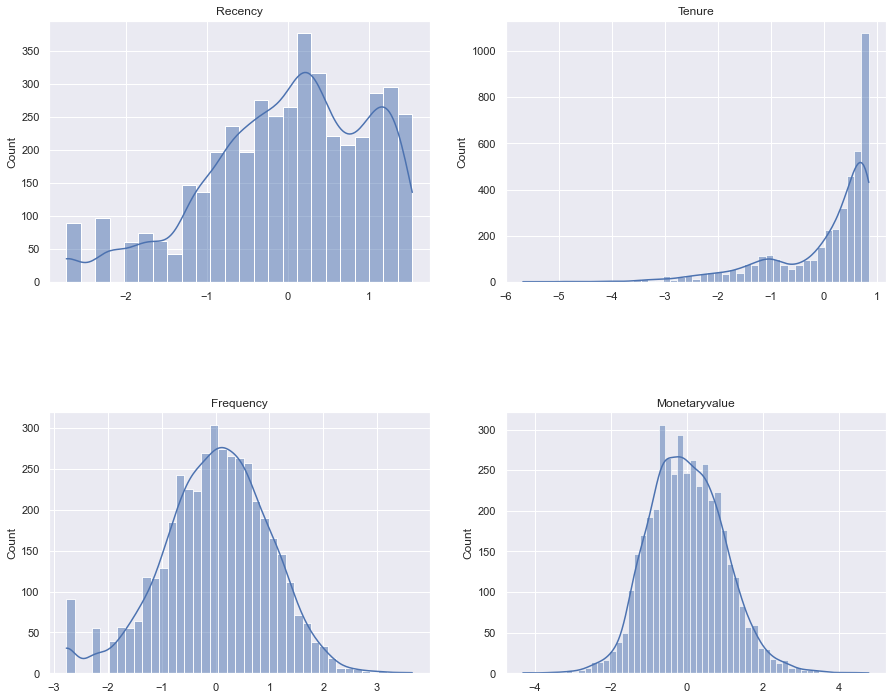

In [57]:
plotting_features_distribution(features)

### 5.2 Run KMeans

We will choosing the number of clusters with elbow method.

Elbow criterion method:
- Plot the number of clusters againts within cluster sum-of-squared-error (SSE) distances from every data point to their cluster center
- Identify an **elbow** in the plot
- Elbow point representing an optimal number of clusters

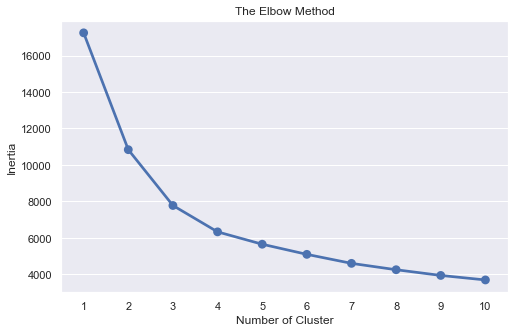

In [58]:
sse = {}
# Fit KMeans and calculate SSE for each k
for i in range(1, 11):
  
    # Initialize KMeans with k clusters and fit it 
    kmeans = KMeans(n_clusters=i, random_state=42).fit(data_log_scaled)
    
    # Assign sum of squared distances to k element of the sse dictionary
    sse[i] = kmeans.inertia_ 

plt.figure(figsize=(8,5))    
# Add the plot title, x and y axis labels
plt.title('The Elbow Method')
plt.xlabel('Number of Cluster')
plt.ylabel('Inertia')

# Plot SSE values for each k stored as keys in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

We can see that our 'elbow' is visible between 3 or 4 clusters. For this project we will build 4 clusters with KMeans

In [59]:
# Initialize KMeans
kmeans = KMeans(n_clusters=4, random_state=42) 

# Fit k-means clustering on the normalized data set
kmeans.fit(data_log_scaled)

# Extract cluster labels
cluster_labels = kmeans.labels_

In [60]:
# Create a new DataFrame by adding a cluster label column to datamart_rfmt
data_4_clusters = data_segment.assign(Cluster=cluster_labels)
data_4_clusters

,Recency,Tenure,Frequency,MonetaryValue,Cluster
Customer ID,,,,,
12346.0,165,361,33,372.86,0
12347.0,3,40,71,1323.32,2
12348.0,74,74,20,222.16,2
12349.0,43,225,102,2671.14,3
12351.0,11,11,21,300.93,2
...,...,...,...,...,...
18283.0,18,294,230,641.77,3
18284.0,67,67,28,461.68,2
18285.0,296,296,12,427.00,0


### 5.3 Analyzing clusters

Cluster
0    1093
1     891
2     828
3    1500
dtype: int64


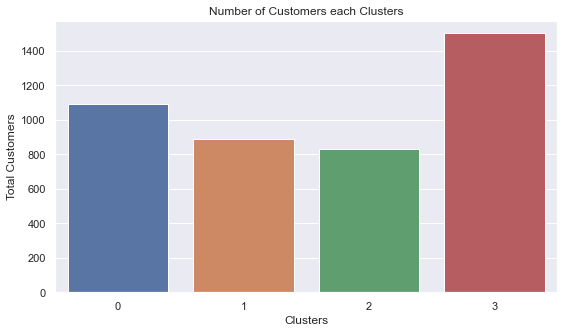

In [61]:
clusters_size = data_4_clusters.groupby('Cluster').size()
print(clusters_size)

plt.figure(figsize=(9,5))
sns.countplot(data_4_clusters['Cluster'])
plt.title('Number of Customers each Clusters')
plt.ylabel('Total Customers')
plt.xlabel('Clusters')
plt.show()

- Cluster 3 has the highest group of our customers
- Cluster 2 has the lowest group of our customers

In [62]:
data_clusters_melt = pd.melt(data_4_clusters.reset_index(), 
        id_vars=['Customer ID', 'Cluster'],
        value_vars=['Recency','Tenure','Frequency','MonetaryValue'],
        var_name = 'Metric',
        value_name = 'Value')

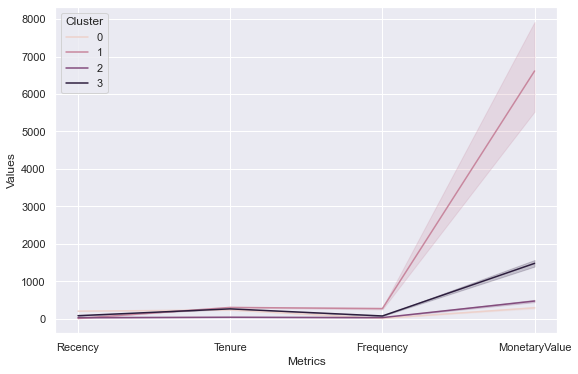

In [63]:
plt.figure(figsize=(9,6))
sns.lineplot(data=data_clusters_melt, x='Metric',y='Value', hue='Cluster')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.show()

#### Recency distribution per cluster

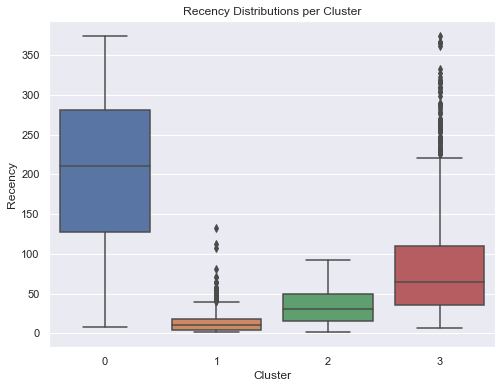

In [64]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Cluster', y='Recency', data=data_4_clusters)
plt.title('Recency Distributions per Cluster')
plt.show()

#### Tenure distribution per clusters

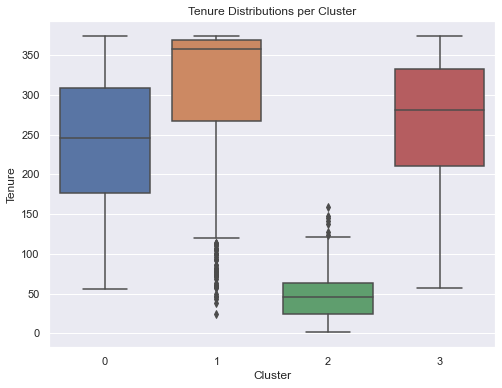

In [65]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Cluster', y='Tenure', data=data_4_clusters)
plt.title('Tenure Distributions per Cluster')
plt.show()

#### Frequency distribution per cluster

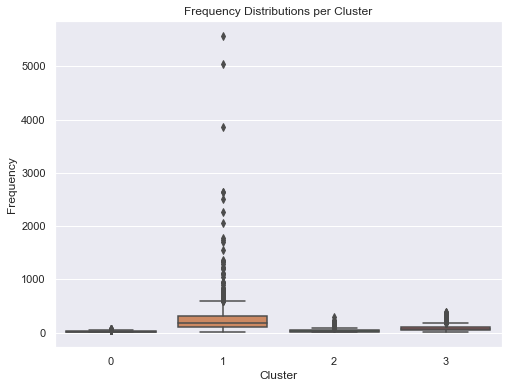

In [66]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Cluster', y='Frequency', data=data_4_clusters)
plt.title('Frequency Distributions per Cluster')
plt.show()

#### Monetary value distribution per cluster

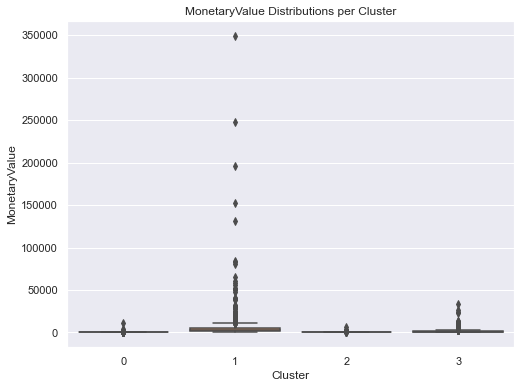

In [67]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Cluster', y='MonetaryValue', data=data_4_clusters)
plt.title('MonetaryValue Distributions per Cluster')
plt.show()

In [68]:
data_4_clusters.groupby('Cluster').mean()

,Recency,Tenure,Frequency,MonetaryValue
Cluster,,,,
0,206.161940,238.962489,15.721866,295.050705
1,13.367003,306.338945,274.120090,6613.604566
2,33.211353,44.881643,34.724638,476.522886
3,85.592667,267.357333,78.324667,1481.486823


### Customer Segment:

#### Cluster 0 traits:
- Mostly customers that more likely to churn, we can see that average of recency is 206 days.
- Unactive customers, but have been with the company for average 238 days
- Despite customers have been with the the company for 238 days in average. Our customers in this cluster tend to have a low orders and we can see that only 295.050705 monetary value on average, the lowest monetaryvalue compare to anoth r clusters

#### Cluster 1 traits:
- Customers that orders most recently, most often orders, and spend the most
- Group of our loyal customers that have tenure 306 days on average, and still orders frequently
- Potential customers for our marketing campaign
- Best group of our customers

#### Cluster 2 traits:
- Mostly new customers with still have a low purchases with only 35 orders on average
- Our customers been with the company for only 45 days on average, but have the last orders for 33 days on average
- Potential group of new customers that more likely to churn

#### Cluster 3 traits:
- Mostly our loyal customers, have been with the company for 267 days on average
- Our customers have a pretty high orders number with average 78 orders and a pretty high monetaryvalue with 1481 on average
- Group of our loyal customers but more likely to churn, since the last orders of our customers in this group is 85 days on average 